In [27]:
import torch
from torch_scatter import scatter_mean
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import os
import pickle
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from methods import mcmc_community, mmca_community
from methods.utils import graph_dynamic

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [28]:
# ---------------初始数据-----------------------------

# 导入默认参数
file_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'parameters/community_data_2.pkl')
with open(file_path, 'rb') as f:
    init_data = pickle.load(f)

epi_paras = torch.tensor(init_data['epi_paras'], dtype=torch.float32).to(device)
soc_paras = torch.tensor(init_data['soc_paras'], dtype=torch.float32).to(device)
features_state = torch.tensor(init_data['init_state'], dtype=torch.float32).to(device)
P_rows, P_cols = init_data['P_matrix'].nonzero()
P_edge_index = torch.tensor(np.array([P_rows, P_cols]), dtype=torch.long).to(device)
communities = init_data['communities']
P_community = init_data['P_community']
P_G = init_data['P_G']

I_rows, I_cols = init_data['I_matrix'].nonzero()
I_edge_index = torch.tensor(np.array([I_rows, I_cols]), dtype=torch.long).to(device)

# # # ---------------初始数据-----------------------------
node_num =  features_state.shape[0]
time_scale = 1000

In [29]:
para_len = 100
soc_paras_mcmc = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_mcmc = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 
features_state_tensor_mcmc = features_state.unsqueeze(0).repeat(para_len, 1, 1).to(device)

mcmc = mcmc_community.MCMC(para_len, node_num, device)
mcmc_features_times, _ = graph_dynamic(time_scale, mcmc, features_state_tensor_mcmc.clone(), epi_paras_mcmc,\
                                        soc_paras_mcmc, P_edge_index, I_edge_index, communities, device)

In [30]:
para_len = 1
soc_paras_mmca = soc_paras.unsqueeze(0).repeat(para_len, 1)
epi_paras_mmca = epi_paras.unsqueeze(0).repeat(para_len, 1, 1) 
features_state_tensor_mmca = features_state.unsqueeze(0).repeat(para_len, 1, 1).to(device)

mmca = mmca_community.MMCA(device)
mmca_features_times, _ = graph_dynamic(time_scale, mmca, features_state_tensor_mmca.clone(), epi_paras_mmca,\
                                        soc_paras_mmca, P_edge_index, I_edge_index, communities, device)

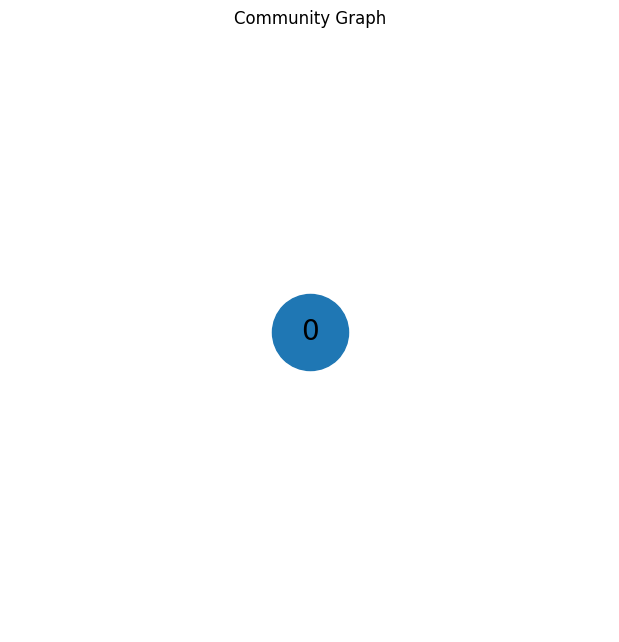

In [31]:
# 可视化社区图
plt.figure(figsize=(6, 6))
# community_pos = nx.spring_layout(community_graph, seed=1)  # 社区图的位置
community_pos = nx.kamada_kawai_layout(P_community)
nx.draw(P_community, community_pos, node_color=range(len(P_community)), cmap='tab10', node_size=3000,
         with_labels=True, font_size=20,font_color='black' )
plt.title("Community Graph")
plt.show()

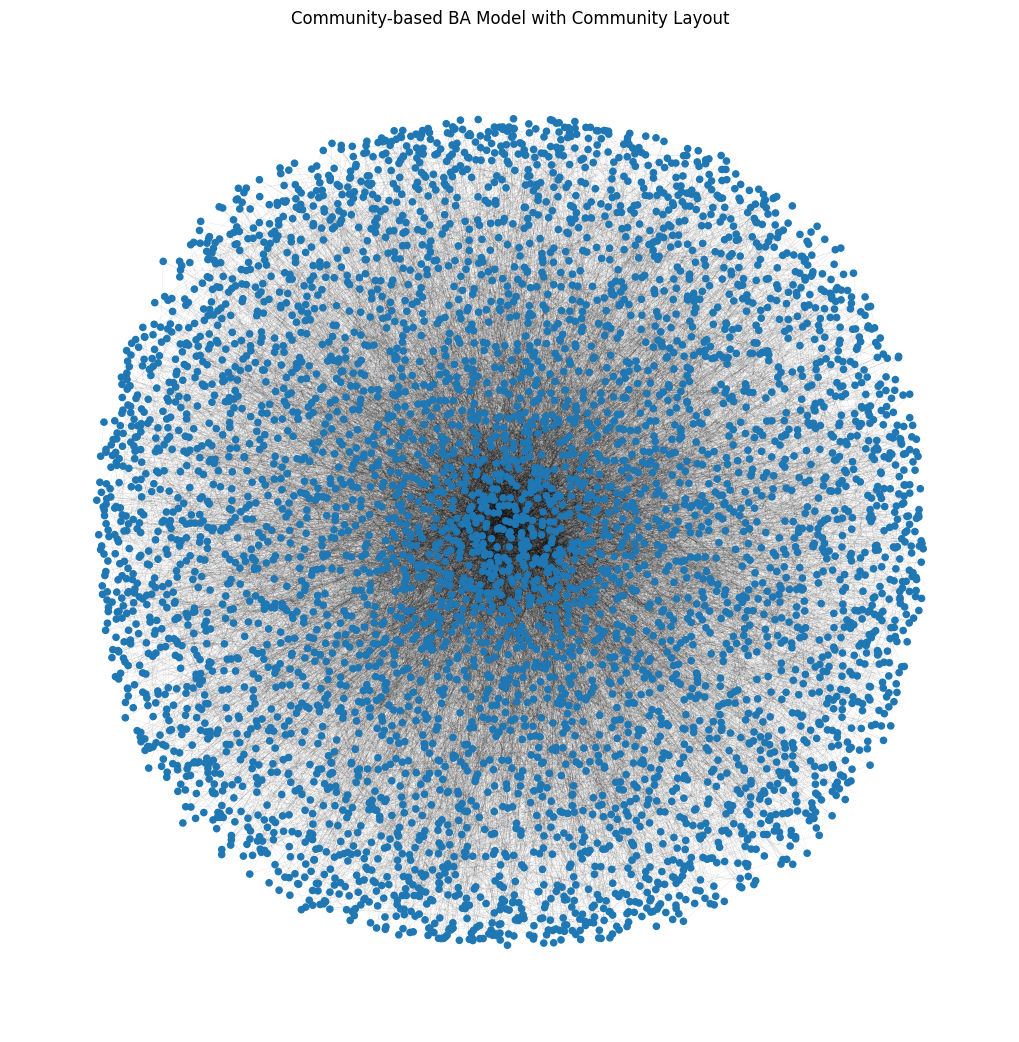

In [32]:
node_pos = nx.spring_layout(P_G, k=0.25, iterations=50)
# 可视化生成的节点图
plt.figure(figsize=(10, 10))
nx.draw(P_G, node_pos, node_color=communities, cmap='tab10', node_size=20, width=0.03)
plt.title("Community-based BA Model with Community Layout")
plt.show()

In [169]:
time_index =0
features_mcmc = mcmc_features_times.squeeze(0)[time_index,...]
features_mmca = mmca_features_times.squeeze(0)[time_index,...]

communities_cpu = torch.tensor(communities)
communities_features_mcmc = scatter_mean(torch.sum(features_mcmc[:,[2,3,4]],dim=1), communities_cpu, dim=0) 
mcmc_mean = torch.mean(features_mcmc[:, [2, 3, 4]].sum(dim=1)).unsqueeze(0)
communities_features_mcmc = torch.cat((communities_features_mcmc, mcmc_mean))

communities_features_mmca = scatter_mean(torch.sum(features_mmca[:,[2,3,4]],dim=1), communities_cpu, dim=0) 
mmca_mean = torch.mean(features_mmca[:, [2, 3, 4]].sum(dim=1)).unsqueeze(0)
communities_features_mmca = torch.cat((communities_features_mmca, mmca_mean))
print(communities_features_mcmc)
print(communities_features_mmca)

tensor([0.3897, 0.3897])
tensor([0.4123, 0.4123])


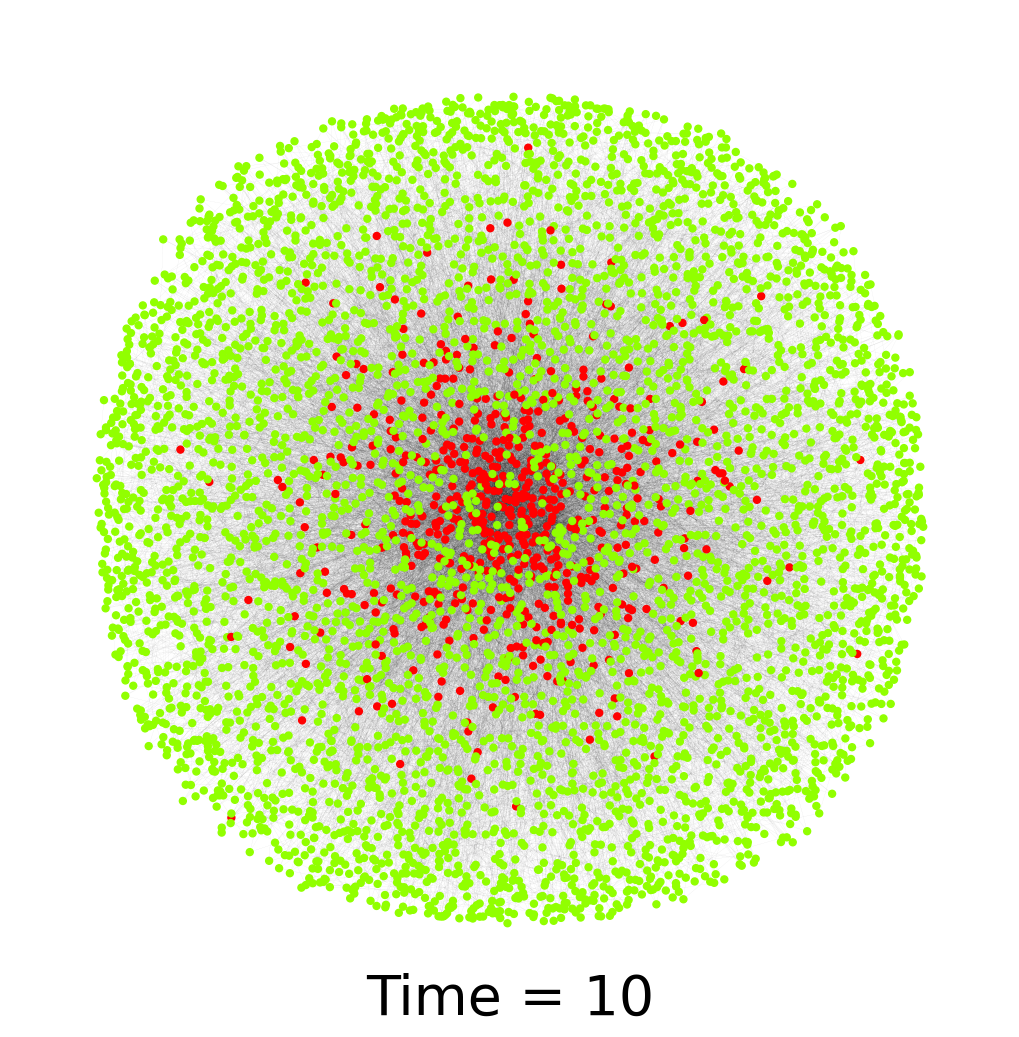

In [170]:
# custom_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF']
custom_colors = ["#91FF00",'#FF0000']
custom_cmap = mcolors.ListedColormap(custom_colors)
# 可视化生成的节点图
node_color = torch.sum(features_mcmc[:,[2,3,4]],dim=1)
plt.figure(figsize=(10, 10))
nx.draw(P_G, node_pos, node_color=node_color, cmap=custom_cmap, node_size=25, width=0.015)
plt.text(0.5, 0.01, f"Time = {time_index}", 
         fontsize=40, ha='center', va='center', transform=plt.gca().transAxes)
# plt.show()
plt.savefig(f'../figs/Diffusion/Community2/t{time_index}.svg', bbox_inches='tight')
plt.savefig(f'../figs/Diffusion/Community2/t{time_index}.png', dpi=600, bbox_inches='tight')

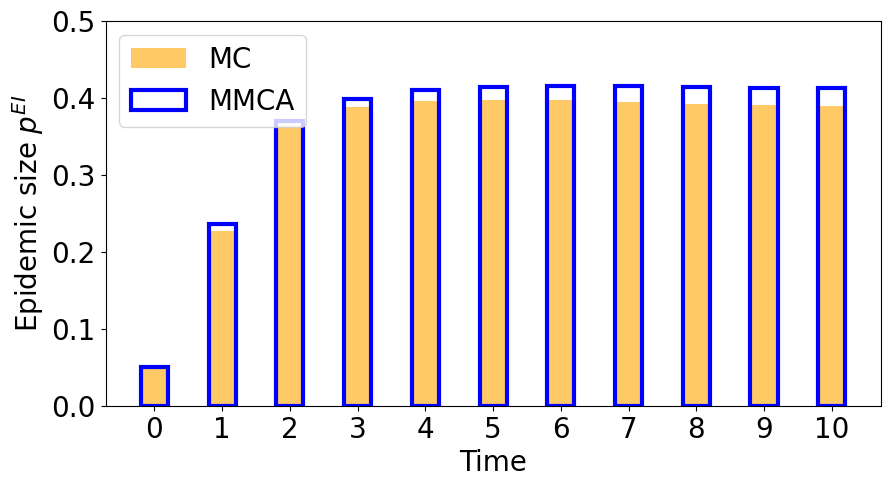

In [171]:
time_index = [0,1,2,3,4,5,6,7,8,9,10]
features_mcmc = mcmc_features_times.squeeze(0)[time_index,...]
features_mmca = mmca_features_times.squeeze(0)[time_index,...]

communities_cpu = torch.tensor(communities)
communities_features_mcmc = scatter_mean(torch.sum(features_mcmc[...,[2,3,4]],dim=2), communities_cpu, dim=1) 
communities_features_mmca = scatter_mean(torch.sum(features_mmca[...,[2,3,4]],dim=2), communities_cpu, dim=1) 



# 数据
data1 = communities_features_mcmc.squeeze(1)
data2 = communities_features_mmca.squeeze(1)

# x轴标签
x_labels = [f'{i}' for i in range(len(data1))]

# 创建图形
plt.figure(figsize=(10, 5))

# 绘制第二个系列（用实体表示）
plt.bar(x_labels, data1, width=0.4, color='orange', alpha=0.6, label='MC')
# 绘制第一个系列（用框表示）
plt.bar(x_labels, data2, width=0.4, color='none', edgecolor='blue', linewidth=3, label='MMCA')
# 添加标题和标签
# plt.title('Bar Chart Comparison')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel('Time', fontsize=20)
plt.ylabel(r'Epidemic size $p^{EI}$', fontsize=20)
plt.ylim(0,0.5)
plt.legend(fontsize=20)

# 显示图形
# plt.show()
plt.savefig(f'../figs/Diffusion/Community2/bar.svg', bbox_inches='tight')